Applies W2V and BERT to classify text by word vector similarity.

# Setup

In [1]:
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
## for processing
import re
import nltk
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for w2v
import gensim
import gensim.downloader as gensim_api
## for bert
import transformers

In [2]:
corpus = pd.read_csv('real whole corpus.csv', names = ['company', 'text'])
corpus = corpus.dropna()

# Preprocessing

Cleaning text, removing stop words, and applying lemmatization.

In [3]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [4]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [5]:
corpus["text_clean"] = corpus["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, 
                                                                            lst_stopwords=lst_stopwords))

# Create target clusters

Create some keywords which can represent the context of each category.

In [6]:
## a pretrained NLP model 
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [7]:
general_words = ['climate','risk','carbon','emission','environment','social','governance','physical','transition',
                 'dioxide','sustainability','green','economy','energy','efficiency','clean','waste','recuperation',
                 'renewable','wind','hydro','solar','global','warming','hydrocarbon','methane','oil','coal','gas',
                 'greenhouse','recycling','composting','soil','water','air','pollution','natural','hazard']

physical_words =  ['heat','wave','cold','floods','droughts','wildfires','storms','change','precipitation','pattern',
                   'sea','level','rise','coastal','hazard','fluvial']

transition_words = ['paris','agreement','regulatory','kyoto','protocol','environmental','protection','agency'] 

Create a dictionary of keywords for each category.

In [8]:
## use this to create a dictionary of keywords for each category 

## functionalize 
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

## create dictionary of this form: {category: [keywords]}
dic_clusters = {}

dic_clusters["GENERAL"] = get_similar_words(general_words, top=30, nlp=nlp)
dic_clusters["PHYSICAL"] = get_similar_words(physical_words, top=30, nlp=nlp)
dic_clusters["TRANSITION"] = get_similar_words(transition_words, top=30, nlp=nlp)


## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

GENERAL :  ['composting', 'reduction', 'global', 'soil', 'conservation'] ... 68
PHYSICAL :  ['precipitation', 'causing', 'hazard', 'wind', 'result'] ... 46
TRANSITION :  ['standards', 'kyoto', 'protection', 'compliance', 'regulations'] ... 38


# Visualization

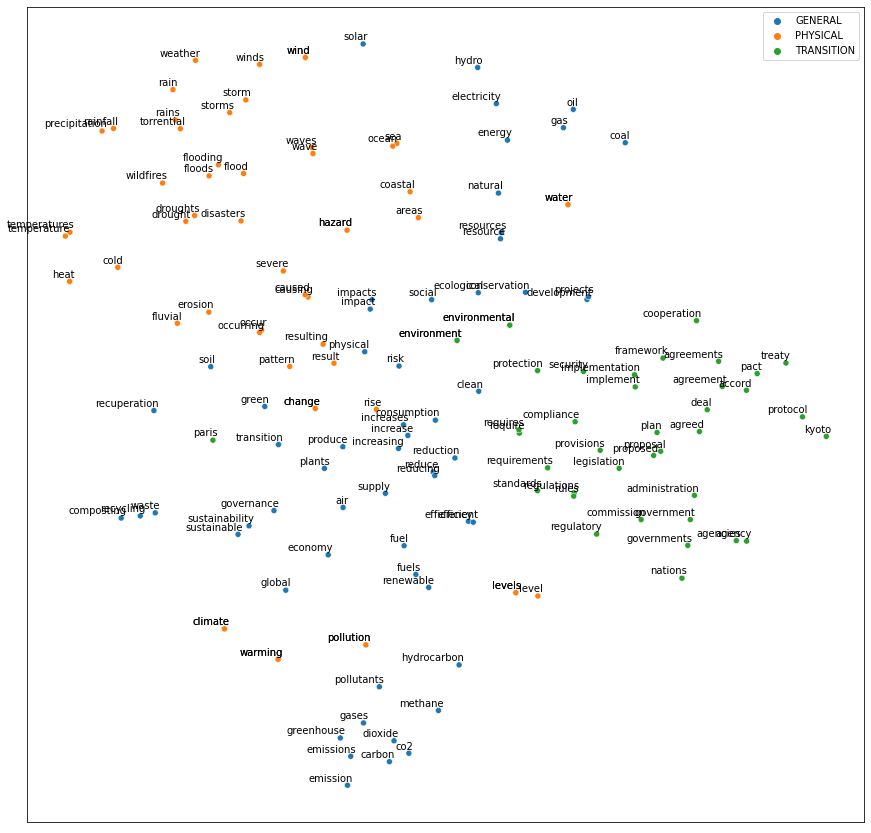

In [9]:
## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf):size], columns=["x","y"], 
                             index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)
        
## plot
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
ax.legend()
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], 
       yticks=[], yticklabels=[])
for i in range(len(dtf)):
    ax.annotate(dtf.index[i], 
               xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

# Feature engineering

BERT doesn’t apply a fixed embedding, instead it looks at the entire sentence and then assigns an embedding to each word. Therefore, the vector BERT assigns to a word is a function of the entire sentence, so that a word can have different vectors based on the contexts.

In [10]:
## use Bert for feature engineering

tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case = True)

nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


0       dear sharehold busi wa mark signific challeng ...
1       type gener revenu sever type contract explain ...
2       patient protect afford care act act requir bus...
3       document de référenc le rapport financi annuel...
4       director robert schechter chairman board chair...
                              ...                        
1425    tabl content lose key personnel includ key man...
1426    integr report see integr report engi contribut...
1427    competit em industri highli competit subject r...
1428    scorecardcompani highlightspag respons page su...
1429    societi environ report articl french commerci ...
Name: text_clean, Length: 1430, dtype: object

Use BERT Word Embedding to represent each text with an array (shape: number of tokens x 768) and then summarize each article into a mean vector.

In [18]:
## function to apply
def utils_bert_embedding(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt, stride = 10, return_overflowing_tokens=True, max_length = 500)[:-1]
    idx = np.array(idx, dtype=np.int64)
    embedding = nlp(idx)

    X = np.array(embedding[0][0][1:-1])
    for i in range(1, len(embedding[0])):
        X = np.concatenate((X, np.array(embedding[0][i][1:-1])), axis=0)
    return X
## create list of news vector
# lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in corpus["text_clean"]]
text_clean = corpus["text_clean"].reset_index(drop=True)
lst_mean_vecs = []
for i in range(len(corpus["text_clean"])):
    txt = text_clean.iloc[i]
    try:
        item = utils_bert_embedding(txt, tokenizer, nlp).mean(0)
        lst_mean_vecs.append(item)
    except:
        lst_mean_vecs.append('error')
        print(i,txt)
        
        

## create the feature matrix (n news x 768)
X = np.array(lst_mean_vecs)

23 valuesenvironment responsibilitysocialresponsibilitycorpor remain commit sustain busi practic activ encourag cultur environment respons regularli engag employe local leader net lea sector work tenant promot environment respons properti energi effici wast diver water effici engag top tenant revenu discus sustain green team led sustain initi educ engag employe commit provid posit engag work environ team member train develop opportun employe believ give back commun extens mission improv live sharehold employe employe health retir engag veral wellb program dollar doer employe match gift san diego habitat human volunt believ noth import compani reput integr serv respons fiduciari commit manag compani benefit sharehold focus maintain good corpor refresh process focus diver oversight environment social govern risk managementoverviewfocuscorpor responsibilityrealti incom strive lead net lea industri environment social govern initiativesto learn visit http valuesenvironment responsibilitysoc

96 take engag dedic knowledg associ serv client well creat real sustain competit advantag broadridg understand thi commit cultur servic thi year took import step enhanc employe pay benefit program bolster depth talent manag team across increas hourli wage expand parent leav vacat day rais charit give strive employ choic passion creat environ everi associ thrive build knowledg skill reward also pursu corpor social respons effort design elev commun touch around broadridg foundat heart compani commun effort partner organ focus provid educ opportun underserv program impact live thousand child around world broadridg proud play also dedic reduc environment thi includ focu reduc paper wast issu align goal busi drive digit everi client convert paperless deliveri sharehold materi contribut fewer tree cut le carbon dioxid environ
98 summari warrant activ set forth outstand exercis warrant weightedaverageexercis price weightedaverag remainingcontractuallif januari issu decemb issu exercis outstan

147 effici ratiocalendar quarterdorian lpgtrajectori valuefleet environment lpg averag effici ratio aer exce vlgc trajectori lpg technic manag vessel measur imo data collect system imo guidelinesdorian lpg commit environment effici reduc greenhous ga ghg emiss trajectori valu intern maritim organ imo ghg global maritim forum get zero refinanc link aer perform conform sustain link loan principl chine propan demand growth new pdh plantsnew chine pdh plant support addit pdh oper rate abov remain addit mtpa pdh demand expect complet year product oil refineri ha decreas sinc govern ration refineri may also decreas domest lpg product even next sever plan project expect add mtpa lpg demand ngl petrochem rongsheng energi huahong new penzun energi lianyungang jiarui binhua new huatai shengfu polymer scienc qixiang haid chemic petrochem ronsheng energi guangdong jinhui sailboat petrochem industri ningbo tianhong wanda petrochem energi ningbo demand ton complet cleaner coal oil altern fuel remov 

233 corpor responsibilitybi design wind power gener steel branch plastic leav new wind ha creat aesthet plea altern energi sourc urban environ bring energi gener closer custom sustain goalsaward recognitionemploye engag voluntari employe turnov woman senior leadership woman employe clean technolog contribut product handprintansi solut support custom effort sustain well improv effici perform durabl thi ha posit effect reduc total materi use increas energi effici reduc greenhous ga emiss support circular economi increas oper one eight ansi growth financi strength reflect lead technolog posit commit thi commit innov ensur continu progress toward goal enabl pervas engin
235 inamaterialrespect infact allowaccesstoortheftofourproprietaryinformationordata ourbusi orfailureof causeustoissuecreditsorpaypenalti andtheyarevulnerabletodamageorinterruptionfromearthquak flood fire powerloss sabotag theoccurrenceofanaturaldisasteroranactofterror therehavebeencallsformorestringentcopyrightprotect tax 

289 broad rang capabl bring partner help grow busi turn grow expertis data analyt digit innov mobil payment enhanc market program attract valu proposit product add signific valu today competit one reason histor gener growth ha outpac retail industri unabl renew walmart program success renew relationship includ five largest ongo low jcpenney januari amazon sam club walmart addit renew key partnership new busi move futur continu use strong capit posit support growth return capit dividend share drive organ growth three sale platform new partner program invest technolog invest next gener data analyt ai digit innov underwrit authent deliv frictionless custom posit u invest core infrastructur explor diversif opportun healthcar financ small busi proprietari oper strong balanc sheet financi maintain strong capit deliv earn growth attract continu execut capit plan dividend share repurchas program subject board regulatori approv prioriti valu cultur drive also drive compani synchroni guid strong

363 andaweakeneddollarcouldincreasethecostofexpensessuchaspayrol util tax andmarketingexpens ormorethanaport oftheadverseimpactofcurrencyexchangeratemov therefor andthoseofourcustomersandsuppli couldbedisruptedbynaturaldisast industrialaccid publichealthissu cybersecurityincid interruptionsofservicefromutil transport telecommun oritsystemsprovid suchasdrought wildfir storm andflood receiveproductionmaterialsfromoursuppli orperformcriticalfunct evenifouroperationsareunaffectedorrecoverquickli ifourcustomerscannottimelyresumetheirownoperationsduetoacatastrophicev theymayreduceorcanceltheirord casualti cost employe govern supplier orappeartofailtoaddress issuesthatgiverisetoreputationalrisk includingthosedescribedthroughoutthi riskfactor section productqu secur orsafetyissu allegationsoflegalnoncompli internalcontrolfailur corporategovernanceissu databreach workplacesafetyincid environmentalincid theuseofourproductsforillegalorobjectionableappl marketingpractic mediastat theconductofoursu

469 mccormick wa hire chief oper offic april ha extens background engin construct tom lack synergi primori busi ha lower margin la heavi manag spend time capit profit texa heavi civil compani serv solar batteri storag micro grid team ha substanti industri experienceprimori renew energi natur ga pipelin market look poi strong even take account declin energi estim natur ga midstream infrastructur invest midstream opportun mile mile natur ga mile natur ga mile natur ga pipelin ingaa north american midstream infrastructur industri info resourc north america forecast million pipelin marketcurr atlant southeast oil ga pipelin spend forecast work california driven replac repow project impel onc cool regul municip ga convers upgrad emiss southeast midwest driven demand growth ga convers propos environment regulatori polici relat climat clean air continu drive solar energi storag megawatt unit natur ga peak cogener plantpow project process market steadi expans project earli natur ga feedstock s

515 risk factor demand servic substanti depend level offshor oil ga explor develop product focu client measur rather qualiti servic differenti ourselv competit could reduc demand futur growth depend significantli level intern oil ga activ abil oper outsid north sea gulf failur attract retain qualifi personnel could advers effect labor problem could advers affect environment regul liabil may increas cost advers affect regul limit foreign ownership compani could reduc price common stock caus owner common stock person lose vote oper lea employe agreement environment conting purchas oblig matter
519 
536 millionglob sale januari good design awardgood design australia awardevinrud aerokuri innov awardrotax aircraft engineawardspropuls systemsdock like expertw continu strive offer best experi whi thi year introduc dock system evinrud outboard idock joystick pilot system leverag exist featur evinrud engin automat compens wind current help custom dock electricw expand rang rotax intern combust

647 game technologycorpor directorycorpor directoryindepend directorsmr gj campbel chairman mr mb yate mr cj henson m ha directormr hk neumannchief execut offic execut directormr de gladstonecompani secretari chief financi officermr ml ludskisecur exchang listingth compani list australian secur home exchang australiasia america share registrycomputershar investor servic pti ltdlevel carrington street sydney nsw australia within aust outsid aust fax tower three intern tower sydney barangaroo avenu sydney nsw australia fax informationainsworth game technolog limit incorpor domicil australia publicli list compani limit head holker street newington nsw australia tel fax email enquiri pacif highway loganholm qld australia fax email gcoleman wayn flood state sale managertel email wflood australiamr kelli frackowski snr sale managertel email kfrackowski rafael rivera way la vega nv fax email enquiri sw avenu deerfield beach fl fax email enquiri game ltd novomat ag astra hous kingsway bridgend

702 chiefexecutiveoffic amongotherprovis lossordestructionofdata includingconfidentialcustomerinform computervirus orothermaliciouscod phishingandcyberattack notallofwhicharewithinourcontrol includingfraudormaliceonthepartofthirdparti accidentaltechnologicalfailur electricalortelecommunicationoutag failuresofcomputerserversorotherdamagetoourpropertyorasset therecanbenoassurancethatthesystemswehavedesignedandimplementedtopreventorlimittheeffectsofcyberincidentsorattackswillbesufficientinpreventingallsuchincidentsorattack theftorlossofintellectualproperti damagetoourreputationwithourcustomersandthemarket temporarydisruptionsofservic failuretomeetcustomerrequirementsorcustomerdissatisfact theftorexposuretolitig damagetoequip whichcouldcauseenvironmentalorsafetyissu ascybersecuritythreatscontinuetoevolv includingdamagetoourreputationorcompetit remediationorincreasedprotectioncost suchasblizzard tornado drought flood extremetemperaturesandhurricanesmaycauseevacuationofpersonnel curtailmento

889 averag quarterli share annual net revenu last three complet fiscal year follow first fiscal quarter second fiscal quarter third fiscal quarter fourth fiscal quarter yearli total weather extrem weather condit area store locat could advers affect busi financi exampl frequent unusu heavi snowfal ice storm rainstorm extrem weather condit prolong period could make difficult custom travel store therebi reduc revenu thi potenti mitig custom abil buy product busi also suscept unseason weather exampl extend period unseason warm temperatur dure winter season cool weather dure summer season could render portion inventori incompat unseason condit could advers affect sale season competit oper woman apparel industri primarili within north american strateg posit custom market segment global fashion landscap fast fashion afford compet basi sever factor includ strateg mix exclus brand offer high qualiti product attain price point proven sophist merchandis plan strategi focu provid except custom ser

947 director pictur left right masaaki john nishibori directorandrew ogawa directordavid remington chairman boardvictor garcia presid chief execut offic directorkathryn jackson compens committe chairgari sawka audit committe chairjohn williford nomin corpor govern committe chaircorpor headquart steuart tower market plaza suit san francisco ca tel account kpmg llpstockhold inquiri investor relat steuart tower market plaza suit san francisco ca tel list common share list nyse symbol counsel perkin coie llp porter drive palo alto ca transfer agent computershar investor servic royal street canton tel center report form copi compani annual report form file secur exchang commiss avail stockhold without charg compani websit upon written request compani meet annual meet stockhold held friday june pdt offic perkin coie porter drive palo alto ca compani websit provid access wide rang inform compani plea visit u relat web inform relat invest compani plea see investor tab websit agenc michael patr

1075 safe harbor matter discus may includ look statement term defin privat secur litig reform act statement reflect current expect actual result may differ subject kind risk enumer compani secur exchang commiss sec compani believ expect reflect statement base reason assumpt made assur assumpt correct expect assumpt involv import risk uncertainti could significantli affect result risk uncertainti includ limit relat weather condit could affect sale profit compani primari market agricultur construct oil ga drill chang raw materialavail commod price competit technolog relationship compani largest custom risk uncertainti relat develop new technolog satisfi custom requir possibl develop competit technolog abil scale product new product without neg impact qualiti cost risk ofoper foreign market risk relat acquisit includ risk integr unanticip liabil conting abil financ invest net work capit need new develop project ani could advers impact ani compani product line risk litig well risk describ 

1137 compani guidanc respect anticip financi result futur period potenti futur growth profit futur busi mix expect regard futur market trend futur perform within specif market statement herein made confer call histor inform statement within mean section secur act section secur exchang act statement subject known unknown risk uncertainti could caus actual result differ materi express impli risk uncertainti includ limit effect global macroeconom condit upon demand product servic b volatil cyclic industri compani serv particularli semiconductor industri c delay capit spend serv market risk uncertainti relat acquisit integr artesyn embed power includ optim reduct global manufactur site e recentoutbreak coronaviru potenti advers impact product manufactur suppli chain oper f accuraci compani estim relat fulfil solar invert product warranti oblig g compani abil realiz plan avoid addit cost solar invert h accuraci compani assumpt financi statement project base impact product price chang may re

1222 commit invest sustain project throughout complet progress project across portfolio back integr corpor green build council silver certif hq oak brook il place bronx ny corner division offic mclean va develop million activ project partner avalonbay kettler share similar valu relat corpor energi effici applianc hvac system construct materi corner one loudoun ashburn va featur repurpos ship contain icon light seat area wa develop instal diy network black dog salvageoper improv ha sign power purchas agreement deliv energi renew resourc wind solar texa asset locat deregul power contract account asset total portfolio commenc replac million squar foot roof new green roof portfolio util led light within common area park irrig system usag time weather pattern elimin unnecessari landscap monitor water usag vehicl charg station avail throughout significantli reduc elimin water usag properti locat warmer climat xeriscap landscap hq properti maintain robust recycl program divert reusabl materi 

1294 dure acquisit process agenc may releas request inform determin qualifi bidder exist draft request propos allow industri comment scope work acquisit strategi final formal request follow evalu submit propos agenc award contract win top idiq contract fiscal number activ task order contract march revenu oftotalrevenuenumb oftask ordersa ofmarch date million alliant acquisit solut engin technolog schedul system technic area tac transform twenti one servic orient busi inform offic solut partner allen engin servic expir date appli idiq task order award idiq run past expir idiq categori manag initi gener servic administr gsa ha undertaken effort improv profession servic schedul result thi initi gsa consolid multipl contract vehicl schedul result booz allen ha consolid scope six schedul one profession servic schedul gsa schedul contract consolid new profession servic schedul advertis integr market solut aim environment servic e financi busi servic fab logist worldwid logworld mission orien

1372 brown brownnationalprogramsisaleadingprogramadministr distributionmanag policyadministr inthousand flood personallin habit andpublicentityriskmanag
1375 copyright right unlock complementari strateg oper financi provid highli engin equip technolog throughout lifecycl leader onsit technolog driven sustain chemistri program throughout lifecycl wellheritag year heritag trust year heritag nalco championcustom base custom relationship intern nation oil companiesand largest blue chipe p north presenc custom focu cultur safeti continu improv focu safeti custom top box financi perform solid cash gener disciplin capit financi perform solid cash gener low capit intensityand high recur
1385 andthesemiconductorindustryasawhol manyofourpurchaseordersarerevis andmaybecancel andweareunabletotimelygeneratereplacementord wemaybuildupexcessinventoryandournetsal includingnaturaldisastersandotherextraordinaryev whichcouldpreventusfromproducingenoughofourproductstomaintainoursalesandsatisfyourcustom in

In [22]:
X.shape

(1278, 768)

In [23]:
dic_clusters

{'GENERAL': ['composting',
  'reduction',
  'global',
  'soil',
  'conservation',
  'increasing',
  'gas',
  'efficiency',
  'hydro',
  'wind',
  'greenhouse',
  'sustainability',
  'dioxide',
  'hazard',
  'waste',
  'pollutants',
  'methane',
  'coal',
  'water',
  'air',
  'emissions',
  'environment',
  'social',
  'warming',
  'risk',
  'reduce',
  'co2',
  'change',
  'efficient',
  'supply',
  'transition',
  'consumption',
  'emission',
  'governance',
  'development',
  'clean',
  'fuel',
  'physical',
  'increases',
  'plants',
  'resource',
  'green',
  'gases',
  'ecological',
  'hydrocarbon',
  'electricity',
  'renewable',
  'produce',
  'natural',
  'reducing',
  'projects',
  'recuperation',
  'energy',
  'levels',
  'sustainable',
  'pollution',
  'solar',
  'resources',
  'oil',
  'carbon',
  'increase',
  'environmental',
  'impact',
  'economy',
  'impacts',
  'climate',
  'fuels',
  'recycling'],
 'PHYSICAL': ['precipitation',
  'causing',
  'hazard',
  'wind',
  '

Each label is identified by a list of words that help BERT to understand the context within the clusters.

In [26]:
tokenizer_original = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [33]:
## function to apply
def utils_bert_embedding_original(txt, tokenizer_original, nlp):
    idx = tokenizer_original.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    X = np.array(embedding[0][0][1:-1])
    return X

In [34]:
dic_y = {k:utils_bert_embedding_original(v, tokenizer_original, nlp).mean(0) for k,v in dic_clusters.items()}

# Model design

Build a model that classifies the news based on the similarity to each target cluster.

Cosine Similarity, a measure of similarity based on the cosine of the angle between two non-zero vectors, which equals the inner product of the same vectors normalized to both have length 1.

In this case, the output is going to be a matrix with shape: number of documents x number of clusters.

In order to run the usual evaluation metrics (Accuracy, AUC, Precision, Recall, …), we have to rescale the scores in each row so that they sum to 1 and decide a category to label the article with.

In [43]:
#--- Model Algorithm ---#
## compute cosine similarities
similarities = np.array([metrics.pairwise.cosine_similarity(X, y.reshape(1,768)).T.tolist()[0] for y in dic_y.values()]).T
## adjust and rescale
labels = list(dic_y.keys())
for i in range(len(similarities)):
    ### assign randomly if there is no similarity
    if sum(similarities[i]) == 0:
        similarities[i] = [0]*len(labels)
        similarities[i][np.random.choice(range(len(labels)))] = 1
    ### rescale so they sum = 1
    similarities[i] = similarities[i] / sum(similarities[i])

## classify the label with highest similarity score
predicted_prob = similarities
predicted = [labels[np.argmax(pred)] for pred in predicted_prob]

In [44]:
predicted_prob

array([[0.33944468, 0.33239697, 0.32815835],
       [0.33620968, 0.33375416, 0.33003616],
       [0.33773033, 0.33451544, 0.32775422],
       ...,
       [0.33516373, 0.33224984, 0.33258643],
       [0.34658439, 0.33366916, 0.31974645],
       [0.34121673, 0.33176469, 0.32701858]])

In [45]:
predicted

['GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'PHYSICAL',
 'PHYSICAL',
 'TRANSITION',
 'GENERAL',
 'PHYSICAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'TRANSITION',
 'GENERAL',
 'TRANSITION',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'PHYSICAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'PHYSICAL',
 'PHYSICAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'PHYSICAL',
 'PHYSICAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'TRANSITION',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'PHYSICAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENERAL',
 'GENER